# Knowledge Dinstillation with Tensorflow 2.x

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
from utils.visualize import plotImages, plotHistory
from utils.train_distillation import DistillationClassificationTrainer

In [3]:
# set some paths
model_dir = Path('bin')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
# Settings
BATCH_SIZE = 128
LR_ADAM = 0.001

# 1.0 Import the Dataset

## 1.1 Download a datast (MNIST)

In [6]:
ds, ds_info = tfds.load(
    'mnist',
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

In [7]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/vitto/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [8]:
label_names = ds_info.features['label'].names
print(label_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [9]:
n_images_train = ds_info.splits['train'].num_examples
n_images_test = ds_info.splits['test'].num_examples

print(f"Number of train images: {n_images_train}")
print(f"Number of test images: {n_images_test}")

Number of train images: 60000
Number of test images: 10000


# 2.0 Prepare the Dataset

In [10]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds['train']
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [11]:
ds_test = ds['test']
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

## 2.1 Visualize the dataset

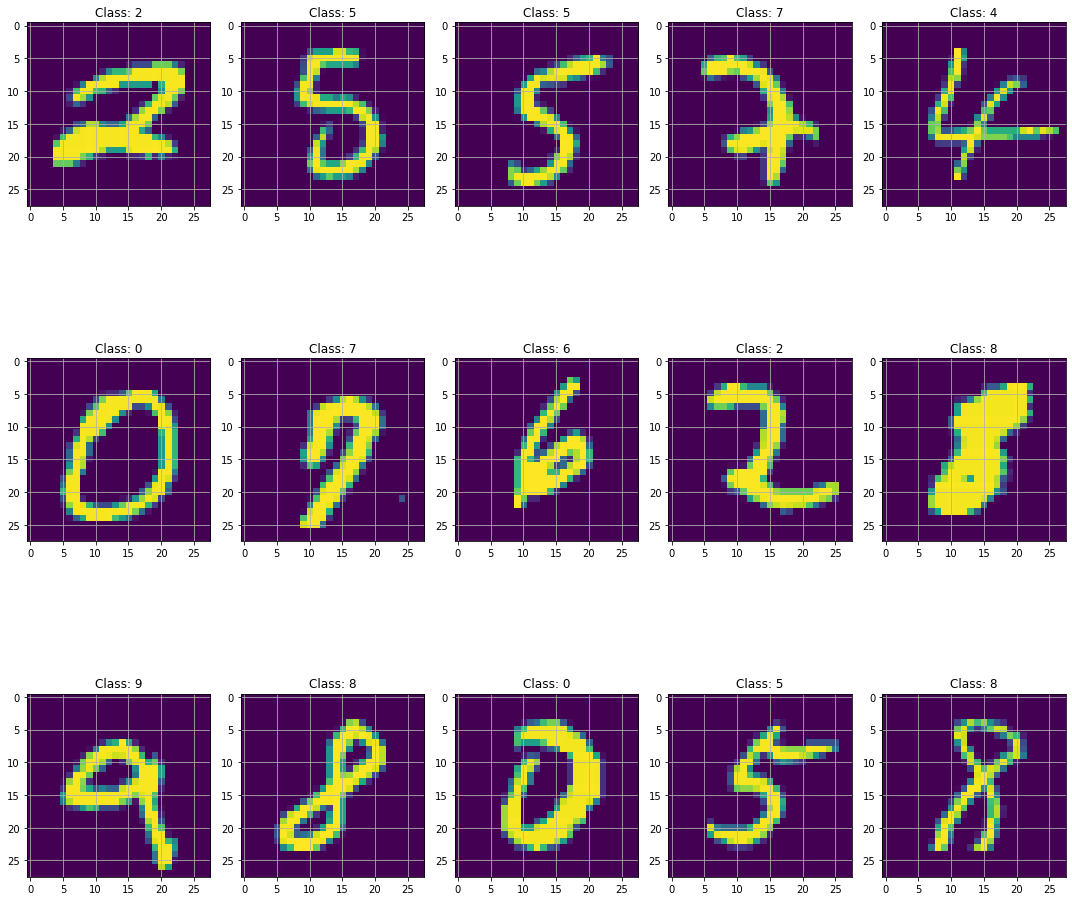

In [12]:
n_images = 12 # n of images to plot

plotImages(iter(ds_train).next(), n_images, label_names)

# 3.0 Train a Small Model

## 3.1 Build the model

In [13]:
small_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),   
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes)
])

In [14]:
small_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
Total params: 19,466
Trainable params: 19,466
Non-trainable params: 0
_________________________________________________________________


## 3.2 Compile the model

In [15]:
small_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_ADAM),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## 3.3 Train the network

In [16]:
history = small_model.fit(
    ds_train,
    epochs=250,
    validation_data=ds_test,
)

Epoch 1/250
469/469 [==============================] - 21s 26ms/step - loss: 1.9992 - sparse_categorical_accuracy: 0.2672 - val_loss: 1.3378 - val_sparse_categorical_accuracy: 0.5639
Epoch 2/250
469/469 [==============================] - 2s 4ms/step - loss: 1.2522 - sparse_categorical_accuracy: 0.5919 - val_loss: 0.9335 - val_sparse_categorical_accuracy: 0.7269
Epoch 3/250
469/469 [==============================] - 2s 4ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.7304 - val_loss: 0.6941 - val_sparse_categorical_accuracy: 0.8017
Epoch 4/250
469/469 [==============================] - 2s 5ms/step - loss: 0.6890 - sparse_categorical_accuracy: 0.8013 - val_loss: 0.5549 - val_sparse_categorical_accuracy: 0.8440
Epoch 5/250
469/469 [==============================] - 2s 4ms/step - loss: 0.5552 - sparse_categorical_accuracy: 0.8411 - val_loss: 0.4611 - val_sparse_categorical_accuracy: 0.8746
Epoch 6/250
469/469 [==============================] - 2s 5ms/step - loss: 0.4638 - sparse_ca

469/469 [==============================] - 2s 4ms/step - loss: 0.0980 - sparse_categorical_accuracy: 0.9714 - val_loss: 0.1007 - val_sparse_categorical_accuracy: 0.9678
Epoch 47/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0999 - sparse_categorical_accuracy: 0.9701 - val_loss: 0.0948 - val_sparse_categorical_accuracy: 0.9705
Epoch 48/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9705 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9709
Epoch 49/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0961 - sparse_categorical_accuracy: 0.9715 - val_loss: 0.0923 - val_sparse_categorical_accuracy: 0.9719
Epoch 50/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0941 - sparse_categorical_accuracy: 0.9717 - val_loss: 0.0929 - val_sparse_categorical_accuracy: 0.9703
Epoch 51/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0963 - sparse_categorical

469/469 [==============================] - 2s 4ms/step - loss: 0.0671 - sparse_categorical_accuracy: 0.9794 - val_loss: 0.0645 - val_sparse_categorical_accuracy: 0.9783
Epoch 92/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0688 - sparse_categorical_accuracy: 0.9789 - val_loss: 0.0734 - val_sparse_categorical_accuracy: 0.9758
Epoch 93/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0687 - sparse_categorical_accuracy: 0.9791 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9729
Epoch 94/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0693 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0654 - val_sparse_categorical_accuracy: 0.9788
Epoch 95/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0622 - sparse_categorical_accuracy: 0.9810 - val_loss: 0.0612 - val_sparse_categorical_accuracy: 0.9792
Epoch 96/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0673 - sparse_categorical

Epoch 136/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.0537 - val_sparse_categorical_accuracy: 0.9821
Epoch 137/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0486 - sparse_categorical_accuracy: 0.9851 - val_loss: 0.0592 - val_sparse_categorical_accuracy: 0.9806
Epoch 138/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0462 - sparse_categorical_accuracy: 0.9852 - val_loss: 0.0556 - val_sparse_categorical_accuracy: 0.9811
Epoch 139/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0512 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0553 - val_sparse_categorical_accuracy: 0.9811
Epoch 140/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0491 - sparse_categorical_accuracy: 0.9845 - val_loss: 0.0508 - val_sparse_categorical_accuracy: 0.9828
Epoch 141/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0492 -

Epoch 181/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0467 - val_sparse_categorical_accuracy: 0.9848
Epoch 182/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0352 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0537 - val_sparse_categorical_accuracy: 0.9818
Epoch 183/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0510 - val_sparse_categorical_accuracy: 0.9838
Epoch 184/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0367 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.0533 - val_sparse_categorical_accuracy: 0.9824
Epoch 185/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0380 - sparse_categorical_accuracy: 0.9878 - val_loss: 0.0472 - val_sparse_categorical_accuracy: 0.9833
Epoch 186/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0370 -

Epoch 226/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0306 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9835
Epoch 227/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0334 - sparse_categorical_accuracy: 0.9892 - val_loss: 0.0443 - val_sparse_categorical_accuracy: 0.9852
Epoch 228/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9901 - val_loss: 0.0445 - val_sparse_categorical_accuracy: 0.9840
Epoch 229/250
469/469 [==============================] - 2s 4ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0454 - val_sparse_categorical_accuracy: 0.9859
Epoch 230/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0296 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0421 - val_sparse_categorical_accuracy: 0.9858
Epoch 231/250
469/469 [==============================] - 2s 5ms/step - loss: 0.0325 -

## 3.4 Evaluate the model

In [17]:
small_model.evaluate(ds_test)

79/79 [==============================] - 0s 1ms/step - loss: 0.0505 - sparse_categorical_accuracy: 0.9836


[0.050451088696718216, 0.9836000204086304]

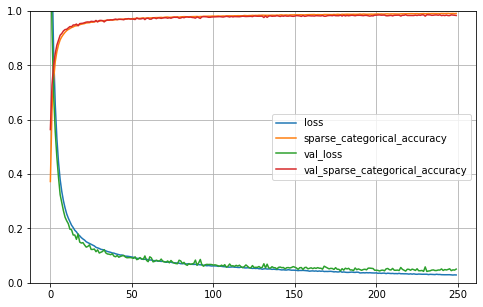

In [18]:
plotHistory(history, set_y_max=1.0)

# 4.0 Train a Cumbersome Model

## 4.1 Build the model

In [19]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='elu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes)
])

In [20]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)       

## 4.2 Compile the model

In [21]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(LR_ADAM),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## 4.3 Train the network

In [22]:
history = cnn_model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_test,
)

Epoch 1/15
469/469 [==============================] - 44s 58ms/step - loss: 0.3305 - sparse_categorical_accuracy: 0.8985 - val_loss: 0.4044 - val_sparse_categorical_accuracy: 0.8719
Epoch 2/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.0426 - val_sparse_categorical_accuracy: 0.9859
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0275 - sparse_categorical_accuracy: 0.9913 - val_loss: 0.0420 - val_sparse_categorical_accuracy: 0.9865
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9924 - val_loss: 0.0233 - val_sparse_categorical_accuracy: 0.9915
Epoch 5/15
469/469 [==============================] - 4s 9ms/step - loss: 0.0151 - sparse_categorical_accuracy: 0.9951 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9880
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0115 - sparse_categori

## 4.4 Evaluate the model

In [23]:
cnn_model.evaluate(ds_test)

79/79 [==============================] - 0s 3ms/step - loss: 0.0333 - sparse_categorical_accuracy: 0.9903


[0.03334885835647583, 0.9902999997138977]

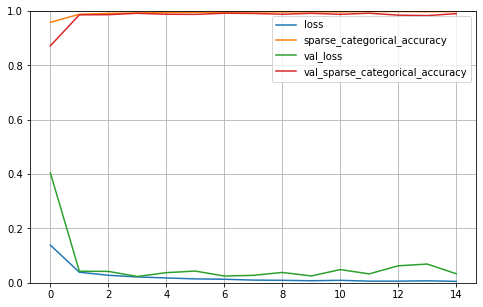

In [24]:
plotHistory(history, set_y_max=1.0)

# 5.0 Train the Small Model with Knowledge Distillation

In [25]:
EPOCHS = 250
LR_ADAM = 0.001
T = 50
LAMBDA = 0.2
SOFT_DISTIL = False # train with soft or hard distillation

## 5.1 Build the model

In [26]:
small_model_w_kd = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, input_shape=ds_info.features['image'].shape, activation='elu', padding='same'),   
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='elu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(ds_info.features['label'].num_classes)
])

## 5.2 Compile the model

In [27]:
distillation_trainer = DistillationClassificationTrainer(small_model_w_kd, cnn_model, T, LAMBDA, 
                                            soft_distillation=SOFT_DISTIL)

In [28]:
optimizer = tf.keras.optimizers.Adam(LR_ADAM)
distillation_trainer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metric=tf.keras.metrics.SparseCategoricalAccuracy(),
    optimizer=optimizer)

## 5.3 Train the network

In [29]:
distillation_trainer.fit(ds_train, epochs=EPOCHS, initial_epoch=0,
    validation_data=ds_test)

Validating validation dataset every 469 steps.

Epoch 1/250
469/469 [==============================] - 3s 6ms/step - Loss: 1.8462 - Accuracy: 0.3649 - Val Loss: 2.1102 - Val Accuracy: 0.5520

Epoch 2/250
469/469 [==============================] - 2s 5ms/step - Loss: 1.3378 - Accuracy: 0.6437 - Val Loss: 1.9572 - Val Accuracy: 0.7516

Epoch 3/250
469/469 [==============================] - 2s 5ms/step - Loss: 1.0241 - Accuracy: 0.7704 - Val Loss: 1.8514 - Val Accuracy: 0.8111

Epoch 4/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.8632 - Accuracy: 0.8267 - Val Loss: 1.7835 - Val Accuracy: 0.8634

Epoch 5/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.7635 - Accuracy: 0.8613 - Val Loss: 1.7377 - Val Accuracy: 0.8857

Epoch 6/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.6949 - Accuracy: 0.8838 - Val Loss: 1.7107 - Val Accuracy: 0.8994

Epoch 7/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.6498 - Accu

469/469 [==============================] - 3s 6ms/step - Loss: 0.4172 - Accuracy: 0.9741 - Val Loss: 1.5621 - Val Accuracy: 0.9735

Epoch 58/250
469/469 [==============================] - 3s 5ms/step - Loss: 0.4169 - Accuracy: 0.9747 - Val Loss: 1.5645 - Val Accuracy: 0.9743

Epoch 59/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.4166 - Accuracy: 0.9749 - Val Loss: 1.5592 - Val Accuracy: 0.9756

Epoch 60/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.4154 - Accuracy: 0.9740 - Val Loss: 1.5583 - Val Accuracy: 0.9756

Epoch 61/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.4141 - Accuracy: 0.9746 - Val Loss: 1.5597 - Val Accuracy: 0.9751

Epoch 62/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.4131 - Accuracy: 0.9752 - Val Loss: 1.5605 - Val Accuracy: 0.9760

Epoch 63/250
469/469 [==============================] - 3s 5ms/step - Loss: 0.4125 - Accuracy: 0.9755 - Val Loss: 1.5588 - Val Accuracy: 0.9780

469/469 [==============================] - 2s 5ms/step - Loss: 0.3832 - Accuracy: 0.9840 - Val Loss: 1.5460 - Val Accuracy: 0.9807

Epoch 114/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3833 - Accuracy: 0.9836 - Val Loss: 1.5472 - Val Accuracy: 0.9817

Epoch 115/250
469/469 [==============================] - 3s 6ms/step - Loss: 0.3832 - Accuracy: 0.9838 - Val Loss: 1.5473 - Val Accuracy: 0.9811

Epoch 116/250
469/469 [==============================] - 3s 6ms/step - Loss: 0.3826 - Accuracy: 0.9840 - Val Loss: 1.5456 - Val Accuracy: 0.9813

Epoch 117/250
469/469 [==============================] - 3s 6ms/step - Loss: 0.3824 - Accuracy: 0.9839 - Val Loss: 1.5451 - Val Accuracy: 0.9807

Epoch 118/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3819 - Accuracy: 0.9844 - Val Loss: 1.5478 - Val Accuracy: 0.9804

Epoch 119/250
469/469 [==============================] - 3s 6ms/step - Loss: 0.3813 - Accuracy: 0.9846 - Val Loss: 1.5468 - Val Accuracy: 

469/469 [==============================] - 2s 5ms/step - Loss: 0.3688 - Accuracy: 0.9879 - Val Loss: 1.5420 - Val Accuracy: 0.9829

Epoch 169/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3686 - Accuracy: 0.9878 - Val Loss: 1.5421 - Val Accuracy: 0.9837

Epoch 170/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3683 - Accuracy: 0.9878 - Val Loss: 1.5446 - Val Accuracy: 0.9811

Epoch 171/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3684 - Accuracy: 0.9878 - Val Loss: 1.5475 - Val Accuracy: 0.9803

Epoch 172/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3684 - Accuracy: 0.9874 - Val Loss: 1.5425 - Val Accuracy: 0.9847

Epoch 173/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3678 - Accuracy: 0.9880 - Val Loss: 1.5412 - Val Accuracy: 0.9842

Epoch 174/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3678 - Accuracy: 0.9877 - Val Loss: 1.5428 - Val Accuracy: 

469/469 [==============================] - 2s 5ms/step - Loss: 0.3598 - Accuracy: 0.9899 - Val Loss: 1.5405 - Val Accuracy: 0.9850

Epoch 224/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3590 - Accuracy: 0.9907 - Val Loss: 1.5418 - Val Accuracy: 0.9837

Epoch 225/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3595 - Accuracy: 0.9907 - Val Loss: 1.5393 - Val Accuracy: 0.9840

Epoch 226/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3593 - Accuracy: 0.9905 - Val Loss: 1.5384 - Val Accuracy: 0.9860

Epoch 227/250
469/469 [==============================] - 3s 6ms/step - Loss: 0.3592 - Accuracy: 0.9904 - Val Loss: 1.5409 - Val Accuracy: 0.9847

Epoch 228/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3589 - Accuracy: 0.9906 - Val Loss: 1.5371 - Val Accuracy: 0.9844

Epoch 229/250
469/469 [==============================] - 2s 5ms/step - Loss: 0.3585 - Accuracy: 0.9908 - Val Loss: 1.5402 - Val Accuracy: 

## 5.4 Evaluate model

In [30]:
small_model_w_kd.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [31]:
small_model_w_kd.evaluate(ds_test)

79/79 [==============================] - 0s 2ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9876


[0.11131098866462708, 0.9865999817848206]